In [1]:
# Largely taken from: http://blog.yhat.com/posts/interactive-geospatial-analysis.html


## UNCOMMENT AND RUN THESE COMMANDS IF YOU DO NOT HAVE IPYWIDGETS 7.0.0 OR BETTER.
#! pip uninstall ipywidgets
#! pip install ipywidgets

In [2]:
#! pip install geopandas
#! pip install tqdm
#! pip install pysal
#! jupyter nbextension enable --py --sys-prefix widgetsnbextension

In [3]:
# basic stuff
import os
import pandas as pd
import numpy as np
from random import randint, uniform
from datetime import datetime
from urllib.request import urlretrieve
from zipfile import ZipFile
import pysal

# geo stuff
import geopandas as gpd
from shapely.geometry import Point
# from ipyleaflet import (Map,
#     Marker,
#     TileLayer, ImageOverlay,
#     Polyline, Polygon, Rectangle, Circle, CircleMarker,
#     GeoJSON,
#     DrawControl
# )

# plotting stuff
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (10.0, 10.0)

# widget stuff
from ipywidgets import interact, HTML, FloatSlider
from IPython.display import clear_output, display

# progress stuff
from tqdm import tqdm_notebook, tqdm_pandas

# turn warnings off
import warnings
warnings.filterwarnings('ignore')

In [4]:
# URL of the file to be downloaded
file_url = "https://github.com/leecming82/dsif-data/raw/main/naturalearth_lowres.zip"

# Local path where the file will be saved
local_path = "naturalearth_lowres.zip"

# Run the wget command
!wget -O {local_path} {file_url}

print(f"File downloaded and saved to: {local_path}")
    
world = gpd.read_file(local_path)

--2024-07-26 07:20:25--  https://github.com/leecming82/dsif-data/raw/main/naturalearth_lowres.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/leecming82/dsif-data/main/naturalearth_lowres.zip [following]
--2024-07-26 07:20:25--  https://raw.githubusercontent.com/leecming82/dsif-data/main/naturalearth_lowres.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 139794 (137K) [application/zip]
Saving to: ‘naturalearth_lowres.zip’

naturalearth_lowres 100%[===================>] 136.52K  --.-KB/s    in 0.008s  

2024-07-26 07:20:25 (15.8 MB/s) - ‘naturalearth_lowres.zip’ saved [139794/139794]


In [5]:
world.head()

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,889953.0,Oceania,Fiji,FJI,5496,"MULTIPOLYGON (((180 -16.06713, 180 -16.55522, ..."
1,58005463.0,Africa,Tanzania,TZA,63177,"POLYGON ((33.90371 -0.95, 34.07262 -1.05982, 3..."
2,603253.0,Africa,W. Sahara,ESH,907,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,37589262.0,North America,Canada,CAN,1736425,"MULTIPOLYGON (((-122.84 49, -122.97421 49.0025..."
4,328239523.0,North America,United States of America,USA,21433226,"MULTIPOLYGON (((-122.84 49, -120 49, -117.0312..."


<Axes: >

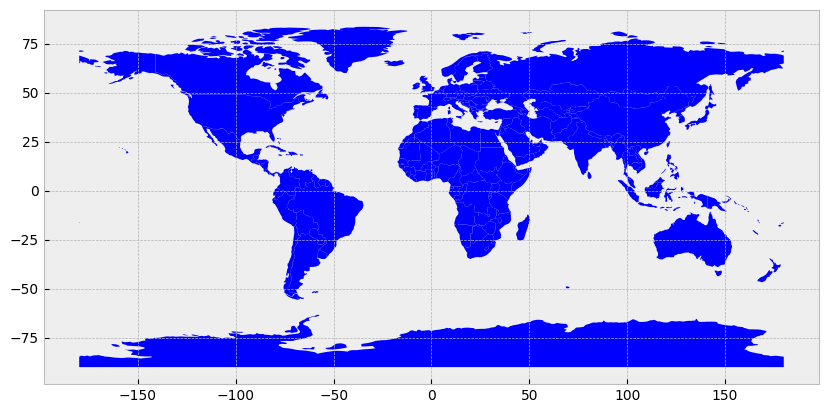

In [6]:
world.plot()

In [7]:
world = world[(world.pop_est>0) & (world.name!="Antarctica")]

<Axes: >

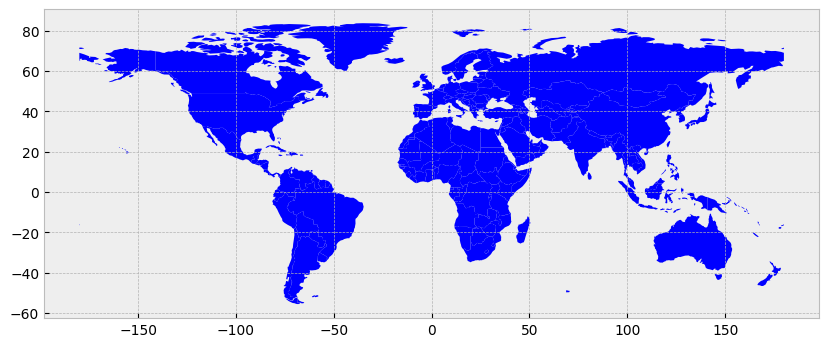

In [8]:
world.plot()

In [9]:
world['gdp_per_cap'] = world.gdp_md_est / world.pop_est

<Axes: >

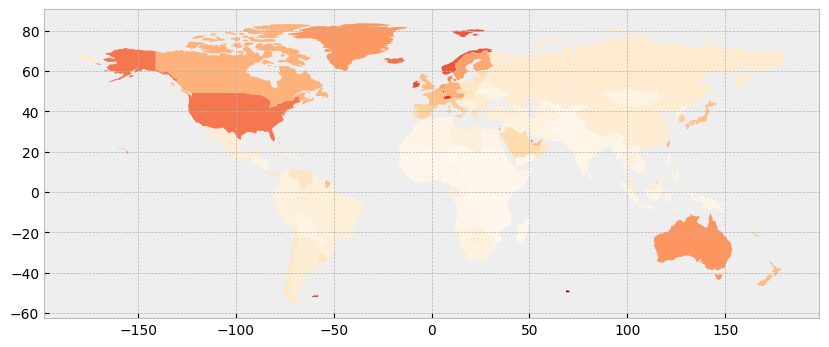

In [10]:
world.plot(column='gdp_per_cap', cmap='OrRd')

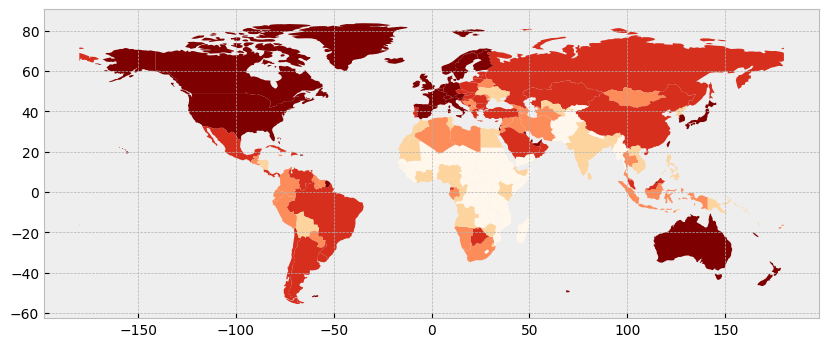

In [11]:
world.plot(column='gdp_per_cap', cmap='OrRd', scheme='quantiles');

In [ ]:
## https://geopandas.org/en/stable/docs/user_guide/mapping.html has good information on the above as well as how to map with layers.

In [12]:
def get_nyc_shape_file(url, filename):

    # download file
    zipped = filename + '.zip'
    urlretrieve('https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile', zipped)
    zipped = os.getcwd() + '/' + zipped

    # unzip file
    to_unzip = ZipFile(zipped, 'r')
    unzipped = os.getcwd() + '/' + filename + '_unzipped'
    to_unzip.extractall(unzipped)
    to_unzip.close()

    # get shape file
    for file in os.listdir(unzipped):
        if file.endswith(".shp"):
            shape_file = unzipped + '/' + file

    # return full file path
    return shape_file

In [13]:
# get shape file path
shape_file_url = 'https://data.cityofnewyork.us/api/geospatial/tqmj-j8zm?method=export&format=Shapefile'
shape_file_dir = 'nyc_boroughs'
file_path = get_nyc_shape_file(shape_file_url,shape_file_dir)

In [14]:
# read and view GeoDataFrame
gdf = gpd.GeoDataFrame.from_file(file_path)
gdf.head()

,boro_code,boro_name,shape_area,shape_leng,geometry
0,3.0,Brooklyn,1.934143e+09,728150.705111,"MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ..."
1,5.0,Staten Island,1.623619e+09,325910.306061,"MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ..."
2,1.0,Manhattan,6.366456e+08,360056.730857,"MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ..."
3,2.0,Bronx,1.187175e+09,463180.578878,"MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ..."
4,4.0,Queens,3.041418e+09,888197.010944,"MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ..."


In [15]:
gdf['geometry']

0    MULTIPOLYGON (((-73.86327 40.58388, -73.86381 ...
1    MULTIPOLYGON (((-74.05051 40.56642, -74.05047 ...
2    MULTIPOLYGON (((-74.01093 40.68449, -74.01193 ...
3    MULTIPOLYGON (((-73.89681 40.79581, -73.89694 ...
4    MULTIPOLYGON (((-73.82645 40.59053, -73.82642 ...
Name: geometry, dtype: geometry

In [16]:
## http://geopandas.org/reference.html <-- lists all attributes and methods of GeoDataFrames!

gdf['geometry'].centroid

0    POINT (-73.94785 40.64476)
1    POINT (-74.15337 40.58084)
2    POINT (-73.96717 40.77727)
3    POINT (-73.86651 40.85264)
4    POINT (-73.81856 40.70766)
dtype: geometry

<Axes: >

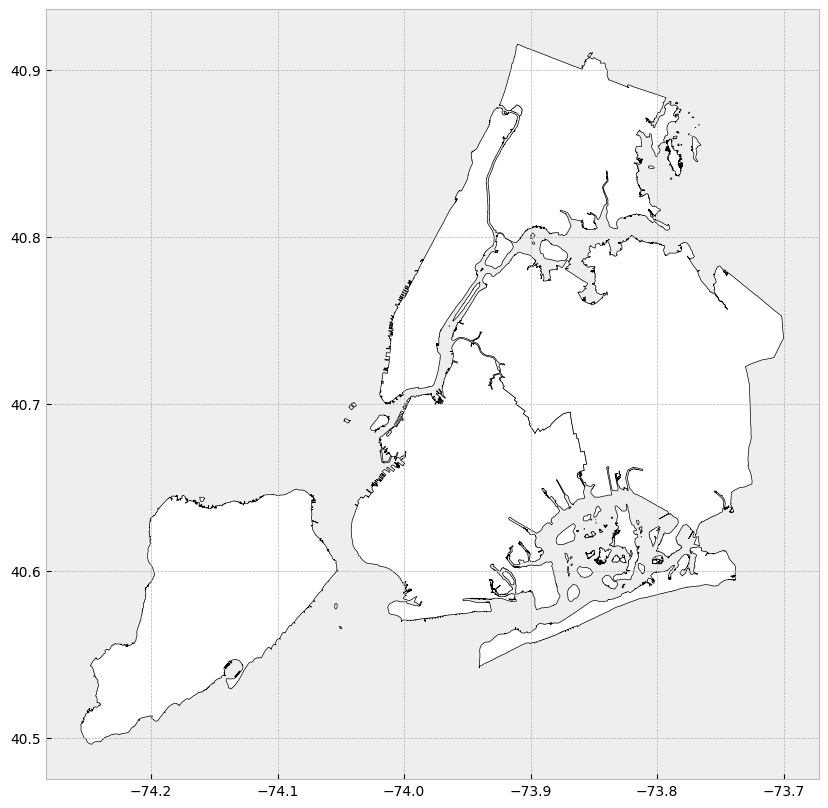

In [17]:
# plot GeoDataFrame
gdf.plot(color='white', edgecolor='black')

<Axes: >

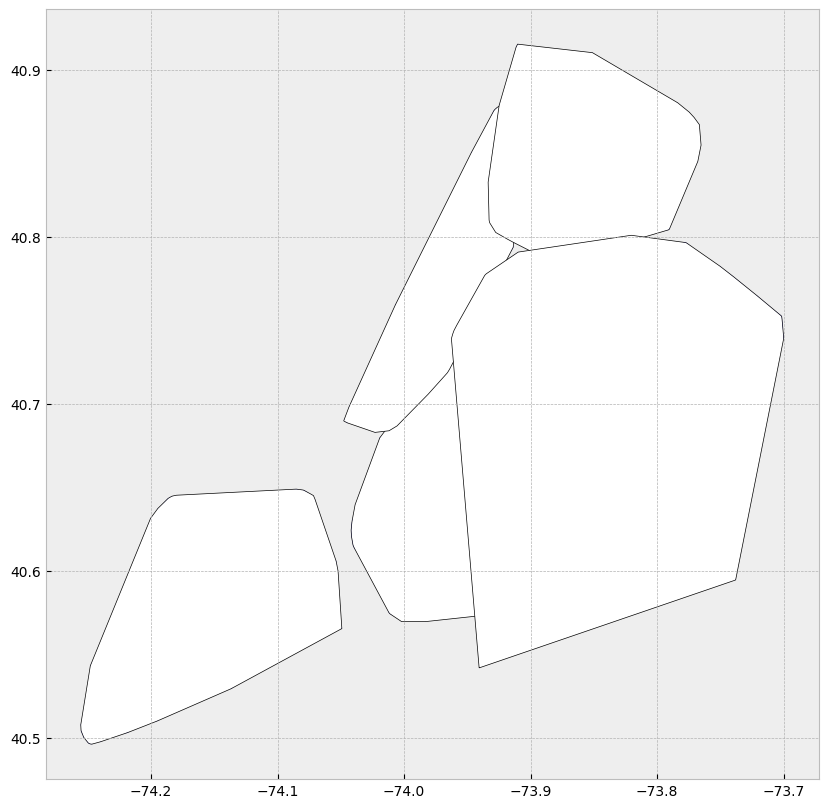

In [18]:
# create convex hulls
hulls = gdf['geometry'].convex_hull

# plot overlay
hulls.plot(ax=gdf.plot(), color='white', edgecolor='black')

<Axes: >

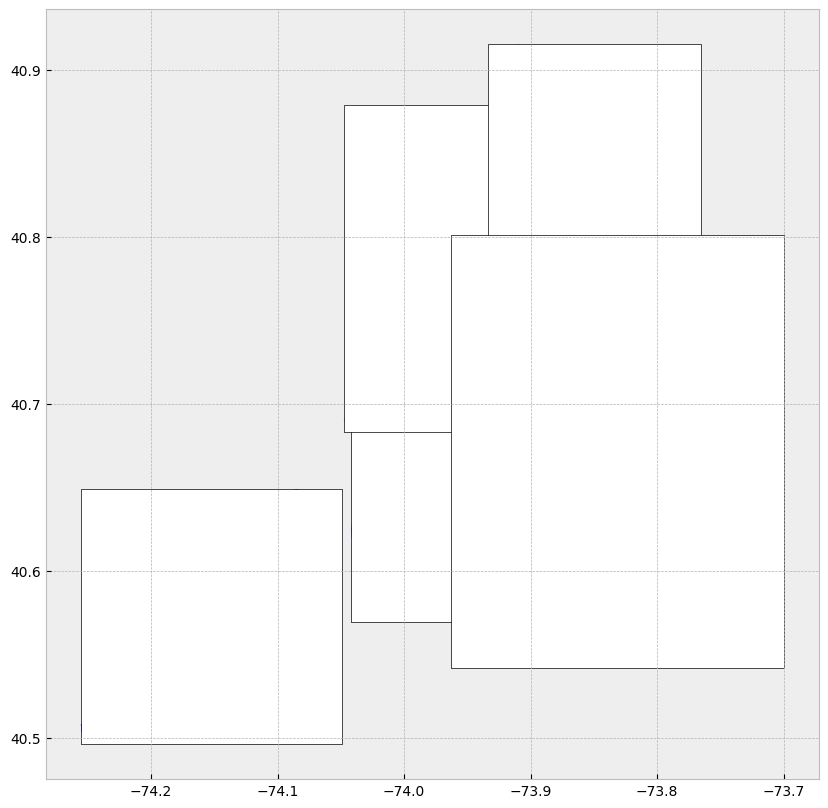

In [19]:
# create envelopes
envelope = gpd.GeoSeries(hulls.envelope)

# plot overlay
envelope.plot(ax=gdf.plot(), color='white', edgecolor='black')

In [20]:
def sim_users(n, p, f):

    # create datetime range
    today = datetime.today().strftime("%m/%d/%Y")
    rng = pd.date_range(today, periods=p, freq=f)

    # get min/max coordinates
    min_x, min_y = gdf['geometry'].bounds.iloc[:,:2].min()
    max_x, max_y = gdf['geometry'].bounds.iloc[:,2:].max()

    # iterate over time datetime range and create user list
    sim_user_list = []
    for ts in tqdm_notebook(rng, desc='Progress', leave=True):
        for j in range(n):
            x = uniform(min_x, max_x)
            y = uniform(min_y, max_y)
            point = Point(x, y)
            sex = randint(0, 1)
            sim_user_list.append([ts, x, y, point, sex])

    # return dataframe
    sim_user_df = pd.DataFrame(sim_user_list, columns=['datetime', 'x', 'y', 'point', 'sex'])
    return sim_user_df

# simulate user data
sim_data = sim_users(100, 24, 'H')
sim_data.head()

Progress:   0%|          | 0/24 [00:00<?, ?it/s]

,datetime,x,y,point,sex
0,2024-07-26,-73.810532,40.794249,POINT (-73.81053226151354 40.79424912811281),1
1,2024-07-26,-74.171800,40.810005,POINT (-74.17179995600985 40.81000548107433),0
2,2024-07-26,-73.934089,40.897220,POINT (-73.93408906847708 40.897220373428894),0
3,2024-07-26,-73.984344,40.541562,POINT (-73.98434361997238 40.541561781564766),1
4,2024-07-26,-74.090082,40.818822,POINT (-74.09008241332943 40.81882188158825),0


In [21]:
sim_data['datetime']

0      2024-07-26 00:00:00
1      2024-07-26 00:00:00
2      2024-07-26 00:00:00
3      2024-07-26 00:00:00
4      2024-07-26 00:00:00
               ...        
2395   2024-07-26 23:00:00
2396   2024-07-26 23:00:00
2397   2024-07-26 23:00:00
2398   2024-07-26 23:00:00
2399   2024-07-26 23:00:00
Name: datetime, Length: 2400, dtype: datetime64[ns]

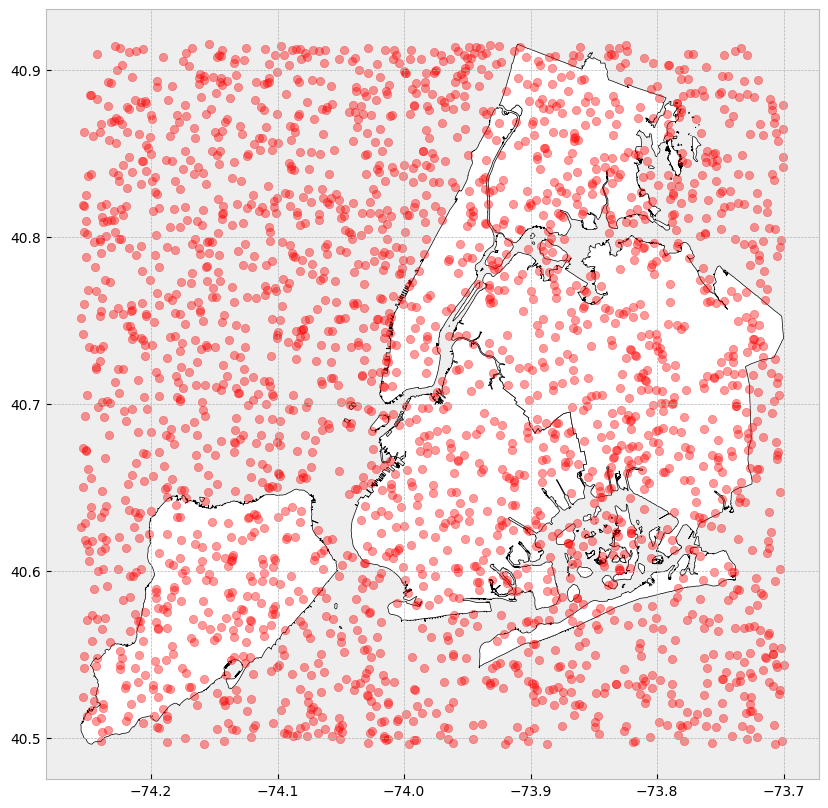

In [22]:
# plot simulated data points
gdf.plot(color='white', edgecolor='black')
plt.scatter(x=sim_data['x'], y=sim_data['y'], alpha=0.4, c='r')

In [23]:
import time
# check if point(s) fall within known geometry - actual
t0 = time.time()
sim_data['contains_1'] = sim_data['point'].map(lambda x: True if gdf.contains(x).any()==True else False)
t1 = time.time()

print(t1 - t0)

4.076810598373413


In [24]:
sim_data['contains_1'].head(10)

0     True
1    False
2    False
3    False
4    False
5     True
6     True
7    False
8     True
9     True
Name: contains_1, dtype: bool

In [25]:
# check if point(s) fall within known geometry - convex hulls
t0 = time.time()
sim_data['contains_2'] = sim_data['point'].map(lambda x: True if hulls.contains(x).any()==True else False)
t1 = time.time()

print(t1 - t0)

0.057881832122802734


In [26]:
# check if point(s) fall within known geometry - envelopes
t0 = time.time()
sim_data['contains_3'] = sim_data['point'].map(lambda x: True if envelope.contains(x).any()==True else False)
t1 = time.time()

print(t1 - t0)

0.08273458480834961


interactive(children=(IntSlider(value=1, description='hour', max=23, min=1), Output()), _dom_classes=('widget-…

<function __main__.make_plot(hour=1)>

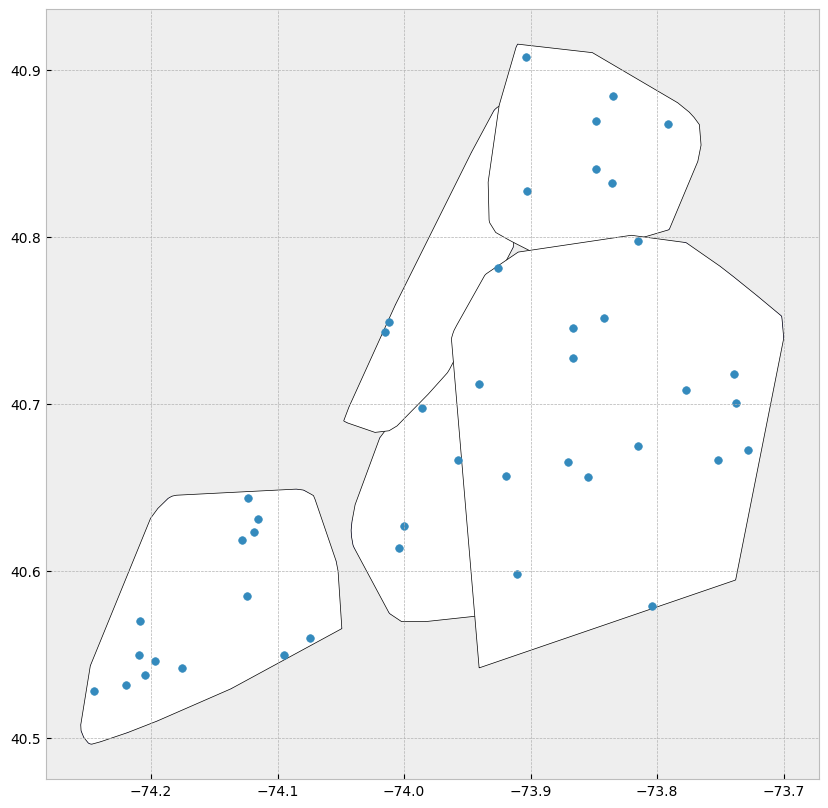

In [27]:
def make_plot(hour=1):

    # filter dataframe
    temp = sim_data[sim_data['contains_2']==True]
    temp=temp[temp['datetime'].dt.hour==hour]

    # plot
    hulls.plot(ax=gdf.plot(), color='white', edgecolor='black')
    plt.scatter(x=temp['x'], y=temp['y'], s=30)

# create widget
interact(make_plot, hour=(1, 23, 1))